In [1]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 19.4 MB/s eta 0:00:00a 0:00:01


In [2]:
import cv2
import numpy as np
import glob
import os

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use tensorflow.keras instead of standalone keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix

2025-04-20 18:17:27.363636: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745173047.547820      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745173047.602098      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import os
import warnings
import itertools
import cv2
import seaborn as sns
import pandas as pd
import numpy  as np
from PIL import Image
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
import keras
from tensorflow.keras.optimizers import AdamW

import tensorflow as tf
import visualkeras
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection   import train_test_split

warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
labels = ["Anthracnose", "Bacterial_Canker", "Cutting_Weevil", "Die_Back", "Gall_Midge","Healthy","Powdery_Mildew","Sooty_Mould"]
img_size = 32

def get_data(data_dir):
    images = []  # List to store images
    class_labels = []  # List to store labels

    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1]  # Convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Reshaping images to preferred size

                # Normalize the image data to 0-1 range
                normalized_arr = resized_arr.astype('float32') / 255.0

                images.append(normalized_arr)
                class_labels.append(class_num)
            except Exception as e:
                print(e)

    # Convert to numpy arrays separately
    X = np.array(images)
    y = np.array(class_labels)

    return X, y

In [6]:
X, y = get_data("/kaggle/input/mld24-dataset/MLD24")

In [7]:
print("Image data shape:", X.shape)
print("Label data shape:", y.shape)

Image data shape: (6400, 32, 32, 3)
Label data shape: (6400,)


In [8]:
# split with a stratified sampling
from sklearn.model_selection import train_test_split
(x_train, x_test, y_train, y_test) = train_test_split(X, y, test_size=0.10, stratify=y, random_state=42)

In [9]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
    test_size=0.18, random_state= 8) # 0.25 x 0.8 = 0.2

In [10]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (4723, 32, 32, 3) - y_train shape: (4723,)
x_val shape: (1037, 32, 32, 3) - y_val shape: (1037,)
x_test shape: (640, 32, 32, 3) - y_test shape: (640,)


In [12]:
class WindowPartition(layers.Layer):
    def __init__(self, window_size):
        super(WindowPartition, self).__init__()
        self.window_size = window_size

    def call(self, x):
        _, height, width, channels = tf.shape(x)
        patch_num_h = height // self.window_size
        patch_num_w = width // self.window_size
        
        # Reshape to create windows
        x = tf.reshape(
            x, 
            (-1, patch_num_h, self.window_size, patch_num_w, self.window_size, channels)
        )
        # Permute dimensions to get windows
        x = tf.transpose(x, [0, 1, 3, 2, 4, 5])
        # Reshape to have a list of windows
        windows = tf.reshape(x, (-1, self.window_size, self.window_size, channels))
        return windows

class WindowConcatenation(layers.Layer):
    def __init__(self, window_size, height, width, channels):
        super(WindowConcatenation, self).__init__()
        self.window_size = window_size
        self.height = height
        self.width = width
        self.channels = channels
        
    def call(self, x):
        patch_num_h = self.height // self.window_size
        patch_num_w = self.width // self.window_size
        
        # Reshape back to windows format
        x = tf.reshape(
            x, 
            (-1, patch_num_h, patch_num_w, self.window_size, self.window_size, self.channels)
        )
        # Permute back to original format
        x = tf.transpose(x, [0, 1, 3, 2, 4, 5])
        # Reshape back to image format
        x = tf.reshape(x, (-1, self.height, self.width, self.channels))
        return x

class LocalWindowAttention(layers.Layer):
    def __init__(self, window_size, dim, num_heads):
        super(LocalWindowAttention, self).__init__()
        self.window_size = window_size
        self.dim = dim
        self.num_heads = num_heads
        
        # Multi-head attention for local processing within a window
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, 
            key_dim=dim // num_heads,
            dropout=0.1
        )
        
    def call(self, x):
        # Reshape the input for attention operation (from window to sequence)
        batch_size = tf.shape(x)[0]
        x_reshaped = tf.reshape(x, (batch_size, -1, self.dim))
        
        # Apply attention
        attention_output = self.attention(x_reshaped, x_reshaped)
        
        # Reshape back to window format
        attention_output = tf.reshape(
            attention_output, 
            (batch_size, self.window_size, self.window_size, self.dim)
        )
        return attention_output

class GlobalWindowAttention(layers.Layer):
    def __init__(self, num_windows, dim, num_heads):
        super(GlobalWindowAttention, self).__init__()
        self.num_windows = num_windows
        self.dim = dim
        self.num_heads = num_heads
        
        # Multi-head attention for global interactions between windows
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, 
            key_dim=dim // num_heads,
            dropout=0.1
        )
        
    def call(self, x):
        # x is expected to be [batch, num_windows, dim]
        
        # Apply global attention across windows
        attention_output = self.attention(x, x)
        return attention_output

class LightweightViTBlock(layers.Layer):
    def __init__(self, window_size, image_size, dim, num_heads, mlp_units):
        super(LightweightViTBlock, self).__init__()
        self.window_size = window_size
        self.image_height = image_size
        self.image_width = image_size
        self.dim = dim
        self.num_windows = (image_size // window_size) ** 2
        
        # Local attention components
        self.window_partition = WindowPartition(window_size)
        self.local_attention = LocalWindowAttention(window_size, dim, num_heads)
        self.window_concatenation = WindowConcatenation(window_size, image_size, image_size, dim)
        
        # Global attention for windows
        self.global_attention = GlobalWindowAttention(self.num_windows, dim, num_heads)
        
        # Layer normalizations and skip connections
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.norm3 = layers.LayerNormalization(epsilon=1e-6)
        
        # MLP block
        self.mlp = self._build_mlp(mlp_units)
        
    def _build_mlp(self, hidden_units):
        mlp_layers = []
        for units in hidden_units:
            mlp_layers.append(layers.Dense(units, activation=tf.nn.gelu))
            mlp_layers.append(layers.Dropout(0.1))
        return keras.Sequential(mlp_layers)
    
    def call(self, x):
        # Input shape: [batch, height, width, channels]
        batch_size = tf.shape(x)[0]
        
        # Layer Norm 1
        x_norm1 = self.norm1(x)
        
        # Local Attention with Window Partitioning
        windows = self.window_partition(x_norm1)
        windows_attended = self.local_attention(windows)
        local_output = self.window_concatenation(windows_attended)
        
        # Skip connection for local attention
        x = x + local_output
        
        # Layer Norm 2
        x_norm2 = self.norm2(x)
        
        # Prepare for global attention (reshape to handle windows as tokens)
        windows_for_global = self.window_partition(x_norm2)
        windows_for_global = tf.reshape(windows_for_global, 
                                       (batch_size, self.num_windows, -1))
        
        # Global Attention between windows
        global_output = self.global_attention(windows_for_global)
        
        # Reshape back and apply window concatenation
        global_output = tf.reshape(global_output, 
                                  (-1, self.window_size, self.window_size, self.dim))
        global_output = self.window_concatenation(global_output)
        
        # Skip connection for global attention
        x = x + global_output
        
        # Layer Norm 3
        x_norm3 = self.norm3(x)
        
        # MLP and skip connection
        mlp_output = self.mlp(tf.reshape(x_norm3, (batch_size, -1, self.dim)))
        mlp_output = tf.reshape(mlp_output, 
                               (batch_size, self.image_height, self.image_width, self.dim))
        
        x = x + mlp_output
        
        return x

# Original Patches class from your notebook
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# Original PatchEncoder class from your notebook
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

def create_lightweight_vit_classifier(input_shape=(28, 28, 3), 
                                     window_size=4,
                                     patch_size=4, 
                                     num_classes=8, 
                                     dim=64, 
                                     num_heads=2, 
                                     mlp_units=[128, 64], 
                                     transformer_layers=1, 
                                     mlp_head_units=[2048, 1024],
                                     training_data=None):
    """
    Create a lightweight ViT model with both local and global attention mechanisms.
    
    Args:
        input_shape: Input image shape (height, width, channels)
        window_size: Size of windows for local attention
        patch_size: Size of patches for the initial patch embedding
        num_classes: Number of output classes
        dim: Embedding dimension
        num_heads: Number of attention heads
        mlp_units: Units in the transformer MLP
        transformer_layers: Number of transformer blocks
        mlp_head_units: Units in the final MLP head
        training_data: Data to adapt normalization layer (optional)
    """
    # Define MLP function for transformer blocks
    def mlp(x, hidden_units, dropout_rate):
        for units in hidden_units:
            x = layers.Dense(units, activation=tf.nn.gelu)(x)
            x = layers.Dropout(dropout_rate)(x)
        return x
        
    inputs = layers.Input(shape=input_shape, name="input_layer")
    
    # Data augmentation
    data_augmentation = keras.Sequential(
        [
            layers.Normalization(),
            layers.Resizing(input_shape[0], input_shape[1]),
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(factor=0.02),
            layers.RandomZoom(height_factor=0.2, width_factor=0.2),
        ],
        name="data_augmentation",
    )
    
    # Only adapt if training data is provided
    if training_data is not None:
        data_augmentation.layers[0].adapt(training_data)
    
    # Apply data augmentation
    augmented = data_augmentation(inputs)
    
    # Calculate the number of patches
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    
    # Patch Embedding (same as original ViT)
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, dim)(patches)
    
    # Apply transformer layers (standard self-attention approach)
    x = encoded_patches
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        # Create a multi-head attention layer
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=dim // num_heads, dropout=0.1
        )(x1, x1)
        # Skip connection 1
        x2 = layers.Add()([attention_output, x])
        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=mlp_units, dropout_rate=0.1)
        # Skip connection 2
        x = layers.Add()([x3, x2])
    
    # Final normalization and classification
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.5)(x)
    
    # MLP Head
    for units in mlp_head_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(0.5)(x)
    
    # Output layer
    outputs = layers.Dense(num_classes)(x)
    
    # Create model
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Usage example with your hyperparameters
def run_experiment_with_lightweight_vit():
    # Define hyperparameters
    learning_rate = 0.001
    weight_decay = 0.0001
    batch_size = 128
    num_epochs = 250
    image_size = 32
    patch_size = 6
    window_size = 4  # Window size for local attention
    dim = 64
    num_heads = 6
    mlp_units = [dim * 2, dim]
    transformer_layers = 5
    mlp_head_units = [2048, 1024]
    num_classes = 8
    
    # Create the model
    model = create_lightweight_vit_classifier(
        input_shape=(image_size, image_size, 3),
        window_size=window_size,
        patch_size=patch_size,
        num_classes=num_classes,
        dim=dim,
        num_heads=num_heads,
        mlp_units=mlp_units,
        transformer_layers=transformer_layers,
        mlp_head_units=mlp_head_units,
        training_data=x_train
    )
    
    # Compile the model
    optimizer = AdamW(
        learning_rate=learning_rate,
        weight_decay=weight_decay
    )
    
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )
    
    # Model summary
    model.summary()
    
    # Set up callbacks with corrected filepath ending in .weights.h5
    checkpoint_filepath = "/kaggle/working//lightweight_vit_model.weights.h5"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
    
    lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.1,
        cooldown=10,
        patience=10,
        verbose=1,
        min_lr=0.1e-7
    )
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        patience=15,
        verbose=1,
        mode='auto'
    )
    
    # Train the model (x_train, y_train should be defined in your notebook)
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_val, y_val),
        callbacks=[checkpoint_callback, lr_reducer, early_stopping],
    )
    
    # Load best weights and evaluate
    model.load_weights(checkpoint_filepath)
    metrics = model.evaluate(x_test, y_test)
    accuracy = metrics[1]  # Accuracy is usually the second metric
    top_5_accuracy = metrics[2]  # Top-5 accuracy is usually the third metric
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
    
    return history, model

# To run the experiment:
# lightweight_vit_history, lightweight_vit_model = run_experiment_with_lightweight_vit()

In [13]:
history, model = run_experiment_with_lightweight_vit()

I0000 00:00:1744704546.420691      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ data_augmentation         │ (None, 32, 32, 3)      │              7 │ input_layer[0][0]      │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patches (Patches)         │ (None, None, 108)      │              0 │ data_augmentation[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_encoder             │ (None, 25, 64)         │          8,576 │ patches[0][0]          │
│ (PatchEncoder)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 25, 64)         │            128 │ patch_encoder[0][0]    │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 25, 64)         │         15,604 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 25, 64)         │              0 │ multi_head_attention[… │
│                           │                        │                │ patch_encoder[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 25, 64)         │            128 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 25, 128)        │          8,320 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 25, 128)        │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 25, 64)         │          8,256 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 25, 64)         │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 25, 64)         │              0 │ dropout_2[0][0],       │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 25, 64)         │            128 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 25, 64)         │         15,604 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├──────────────────────

 Total params: 2,410,387 (9.19 MB)

 Trainable params: 2,410,380 (9.19 MB)

 Non-trainable params: 7 (32.00 B)

Epoch 1/250
37/37 ━━━━━━━━━━━━━━━━━━━━ 29s 69ms/step - accuracy: 0.3781 - loss: 1.6057 - top-5-accuracy: 0.8438 - val_accuracy: 0.7821 - val_loss: 0.6383 - val_top-5-accuracy: 0.9942 - learning_rate: 0.0010
Epoch 2/250
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6812 - loss: 0.8187 - top-5-accuracy: 0.9901 - val_accuracy: 0.8071 - val_loss: 0.5535 - val_top-5-accuracy: 0.9961 - learning_rate: 0.0010
Epoch 3/250
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7701 - loss: 0.6052 - top-5-accuracy: 0.9970 - val_accuracy: 0.8091 - val_loss: 0.5089 - val_top-5-accuracy: 0.9981 - learning_rate: 0.0010
Epoch 4/250
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7826 - loss: 0.5720 - top-5-accuracy: 0.9985 - val_accuracy: 0.8496 - val_loss: 0.4268 - val_top-5-accuracy: 1.0000 - learning_rate: 0.0010
Epoch 5/250
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8156 - loss: 0.4690 - top-5-accuracy: 0.9993 - val_accuracy: 0.8554 - val_loss: 0.3771 - val_top-5-accuracy: 

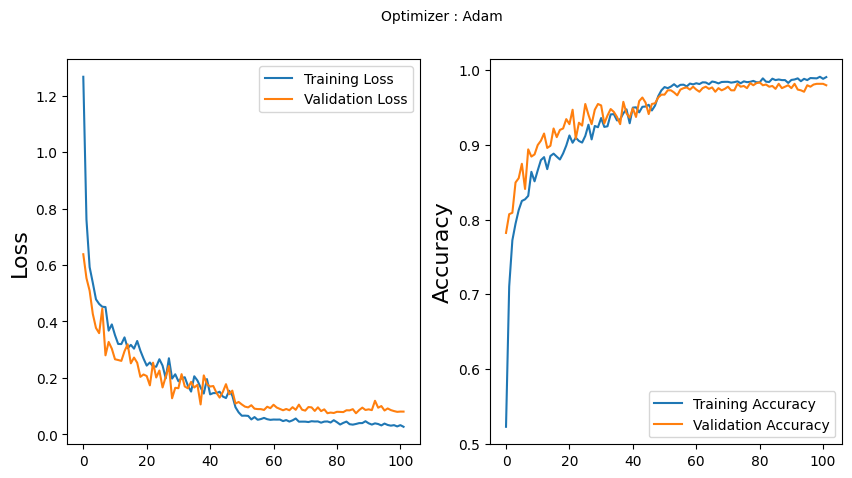

In [14]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

Dual attention ViT

In [11]:
class WindowPartition(layers.Layer):
    def __init__(self, window_size):
        super(WindowPartition, self).__init__()
        self.window_size = window_size

    def call(self, x):
        # Get shape components but keep them as tensors, not concrete values
        shape = tf.shape(x)
        batch_size = shape[0]
        height = shape[1]
        width = shape[2]
        channels = shape[3]
        
        # Ensure dimensions are compatible with window size
        # This is crucial - we need to make sure height and width are divisible by window_size
        # We'll use tf.assert to catch errors early
        tf.assert_equal(tf.math.floormod(height, self.window_size), 0, 
                        message=f"Height must be divisible by window size {self.window_size}")
        tf.assert_equal(tf.math.floormod(width, self.window_size), 0,
                        message=f"Width must be divisible by window size {self.window_size}")
        
        patch_num_h = height // self.window_size
        patch_num_w = width // self.window_size
        
        # Use dynamic shapes for the reshape operation
        x = tf.reshape(
            x, 
            [batch_size, patch_num_h, self.window_size, patch_num_w, self.window_size, channels]
        )
        # Permute dimensions to get windows
        x = tf.transpose(x, [0, 1, 3, 2, 4, 5])
        # Reshape to have a list of windows - use dynamic shape
        windows = tf.reshape(x, [batch_size * patch_num_h * patch_num_w, self.window_size, self.window_size, channels])
        return windows

class WindowConcatenation(layers.Layer):
    def __init__(self, window_size, height, width, channels):
        super(WindowConcatenation, self).__init__()
        self.window_size = window_size
        self.height = height
        self.width = width
        self.channels = channels
        
    def call(self, x):
        # Get shape components
        shape = tf.shape(x)
        patch_num_h = self.height // self.window_size
        patch_num_w = self.width // self.window_size
        total_windows = patch_num_h * patch_num_w
        batch_size = shape[0] // total_windows
        
        # Reshape back to windows format with explicit dimensions
        x = tf.reshape(
            x, 
            [batch_size, patch_num_h, patch_num_w, self.window_size, self.window_size, self.channels]
        )
        # Permute back to original format
        x = tf.transpose(x, [0, 1, 3, 2, 4, 5])
        # Reshape back to image format
        x = tf.reshape(x, [batch_size, self.height, self.width, self.channels])
        return x

class LocalWindowAttention(layers.Layer):
    def __init__(self, window_size, dim, num_heads):
        super(LocalWindowAttention, self).__init__()
        self.window_size = window_size
        self.dim = dim
        self.num_heads = num_heads
        
        # Multi-head attention for local processing within a window
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, 
            key_dim=dim // num_heads,
            dropout=0.1
        )
        
    def call(self, x):
        # Get batch size without unpacking
        batch_size = tf.shape(x)[0]
        
        # Calculate flattened size
        flattened_size = self.window_size * self.window_size
        
        # Reshape the input for attention operation (from window to sequence)
        x_reshaped = tf.reshape(x, [batch_size, flattened_size, self.dim])
        
        # Apply attention
        attention_output = self.attention(x_reshaped, x_reshaped)
        
        # Reshape back to window format
        attention_output = tf.reshape(
            attention_output, 
            [batch_size, self.window_size, self.window_size, self.dim]
        )
        return attention_output

class GlobalWindowAttention(layers.Layer):
    def __init__(self, num_windows, dim, num_heads):
        super(GlobalWindowAttention, self).__init__()
        self.num_windows = num_windows
        self.dim = dim
        self.num_heads = num_heads
        
        # Multi-head attention for global interactions between windows
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, 
            key_dim=dim // num_heads,
            dropout=0.1
        )
        
    def call(self, x):
        # x is expected to be [batch, num_windows, dim]
        
        # Apply global attention across windows
        attention_output = self.attention(x, x)
        return attention_output

class LightweightViTBlock(layers.Layer):
    def __init__(self, window_size, image_size, dim, num_heads, mlp_units):
        super(LightweightViTBlock, self).__init__()
        self.window_size = window_size
        self.image_height = image_size
        self.image_width = image_size
        self.dim = dim
        self.num_windows = (image_size // window_size) ** 2
        
        # Local attention components
        self.window_partition = WindowPartition(window_size)
        self.local_attention = LocalWindowAttention(window_size, dim, num_heads)
        self.window_concatenation = WindowConcatenation(window_size, image_size, image_size, dim)
        
        # Global attention for windows
        self.global_attention = GlobalWindowAttention(self.num_windows, dim, num_heads)
        
        # Layer normalizations and skip connections
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.norm3 = layers.LayerNormalization(epsilon=1e-6)
        
        # MLP block
        self.mlp = self._build_mlp(mlp_units)
        
    def _build_mlp(self, hidden_units):
        mlp_layers = []
        for units in hidden_units:
            mlp_layers.append(layers.Dense(units, activation=tf.nn.gelu))
            mlp_layers.append(layers.Dropout(0.1))
        return keras.Sequential(mlp_layers)
    
    def call(self, x):
        # Get batch size without unpacking
        batch_size = tf.shape(x)[0]
        
        # Layer Norm 1
        x_norm1 = self.norm1(x)
        
        # Local Attention with Window Partitioning
        windows = self.window_partition(x_norm1)
        windows_attended = self.local_attention(windows)
        local_output = self.window_concatenation(windows_attended)
        
        # Skip connection for local attention
        x = x + local_output
        
        # Layer Norm 2
        x_norm2 = self.norm2(x)
        
        # Prepare for global attention (reshape to handle windows as tokens)
        windows_for_global = self.window_partition(x_norm2)
        
        # Calculate window dimensions explicitly to avoid shape issues
        num_windows = (self.image_height // self.window_size) * (self.image_width // self.window_size)
        window_size_squared = self.window_size * self.window_size
        
        # Reshape with explicit batch dimension to avoid shape inference issues
        windows_for_global_reshaped = tf.reshape(
            windows_for_global, 
            [batch_size, num_windows, window_size_squared * self.dim]
        )
        
        # Global Attention between windows
        global_output = self.global_attention(windows_for_global_reshaped)
        
        # Reshape back for window concatenation
        global_windows = tf.reshape(
            global_output, 
            [batch_size * num_windows, self.window_size, self.window_size, self.dim]
        )
        
        global_output_concatenated = self.window_concatenation(global_windows)
        
        # Skip connection for global attention
        x = x + global_output_concatenated
        
        # Layer Norm 3
        x_norm3 = self.norm3(x)
        
        # MLP and skip connection
        # Reshape for MLP but preserve batch dimension
        mlp_input = tf.reshape(x_norm3, [batch_size, -1, self.dim])
        mlp_output = self.mlp(mlp_input)
        mlp_output_reshaped = tf.reshape(
            mlp_output, 
            [batch_size, self.image_height, self.image_width, self.dim]
        )
        
        x = x + mlp_output_reshaped
        
        return x

# Original Patches class from your notebook
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# Original PatchEncoder class from your notebook
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

def create_lightweight_vit_classifier(input_shape=(32, 32, 3), 
                                     window_size=4,
                                     patch_size=8, 
                                     num_classes=8, 
                                     dim=64, 
                                     num_heads=6, 
                                     mlp_units=[128, 64], 
                                     transformer_layers=5, 
                                     mlp_head_units=[2048, 1024],
                                     training_data=None):
    """
    Create a lightweight ViT model with both local and global attention mechanisms.
    """
    inputs = layers.Input(shape=input_shape, name="input_layer")
    
    # Data augmentation
    data_augmentation = keras.Sequential(
        [
            layers.Normalization(),
            layers.Resizing(input_shape[0], input_shape[1]),
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(factor=0.02),
            layers.RandomZoom(height_factor=0.2, width_factor=0.2),
        ],
        name="data_augmentation",
    )
    
    # Only adapt if training data is provided
    if training_data is not None:
        data_augmentation.layers[0].adapt(training_data)
    
    # Apply data augmentation
    augmented = data_augmentation(inputs)
    
    # Calculate the number of patches
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    
    # Patch Embedding
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, dim)(patches)
    
    # Reshape encoded patches to 2D spatial format for LightweightViTBlock
    # Calculate the spatial dimensions
    height = input_shape[0] // patch_size
    width = input_shape[1] // patch_size
    x = layers.Reshape((height, width, dim))(encoded_patches)
    
    # Apply LightweightViTBlock layers
    for _ in range(transformer_layers):
        x = LightweightViTBlock(
            window_size=window_size,
            image_size=height,  # Using the height after patch embedding
            dim=dim,
            num_heads=num_heads,
            mlp_units=mlp_units
        )(x)
    
    # Final processing
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Reshape((num_patches, dim))(x)  # Reshape back to sequence format
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.5)(x)
    
    # MLP Head
    for units in mlp_head_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(0.5)(x)
    
    # Output layer
    outputs = layers.Dense(num_classes)(x)
    
    # Create model
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Usage example with your hyperparameters
def run_experiment_with_lightweight_vit():
    # Define hyperparameters
    learning_rate = 0.001
    weight_decay = 0.0001
    batch_size = 128
    num_epochs = 250
    image_size = 32
    patch_size = 8  # Changed from 6 to 8 to get 4×4 feature map
    window_size = 4  # Window size for local attention
    dim = 64
    num_heads = 6
    mlp_units = [dim * 2, dim]
    transformer_layers = 5
    mlp_head_units = [2048, 1024]
    num_classes = 8
    
    # Create the model
    model = create_lightweight_vit_classifier(
        input_shape=(image_size, image_size, 3),
        window_size=window_size,
        patch_size=patch_size,
        num_classes=num_classes,
        dim=dim,
        num_heads=num_heads,
        mlp_units=mlp_units,
        transformer_layers=transformer_layers,
        mlp_head_units=mlp_head_units,
        training_data=x_train
    )
    
    # Compile the model
    optimizer = AdamW(
        learning_rate=learning_rate,
        weight_decay=weight_decay
    )
    
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )
    
    # Model summary
    model.summary()
    
    # Set up callbacks with corrected filepath ending in .weights.h5
    checkpoint_filepath = "/kaggle/working//lightweight_vit_model.weights.h5"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
    
    lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.1,
        cooldown=10,
        patience=10,
        verbose=1,
        min_lr=0.1e-7
    )
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        patience=15,
        verbose=1,
        mode='auto'
    )
    
    # Train the model (x_train, y_train should be defined in your notebook)
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_val, y_val),
        callbacks=[checkpoint_callback, lr_reducer, early_stopping],
    )
    
    # Load best weights and evaluate
    model.load_weights(checkpoint_filepath)
    metrics = model.evaluate(x_test, y_test)
    accuracy = metrics[1]  # Accuracy is usually the second metric
    top_5_accuracy = metrics[2]  # Top-5 accuracy is usually the third metric
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
    
    return history, model

# To run the experiment:
# lightweight_vit_history, lightweight_vit_model = run_experiment_with_lightweight_vit()

In [12]:
history, model = run_experiment_with_lightweight_vit()

I0000 00:00:1745173117.699105      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 32, 32, 3)           │               7 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patches (Patches)                    │ (None, None, 192)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_encoder (PatchEncoder)         │ (None, 16, 64)              │          13,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lightweight_vi_t_block               │ (None, 4, 4, 64)            │         279,528 │
│ (LightweightViTBlock)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lightweight_vi_t_block_1             │ (None, 4, 4, 64)            │         279,528 │
│ (LightweightViTBlock)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lightweight_vi_t_block_2             │ (None, 4, 4, 64)            │         279,528 │
│ (LightweightViTBlock)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lightweight_vi_t_block_3             │ (None, 4, 4, 64)            │         279,528 │
│ (LightweightViTBlock)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lightweight_vi_t_block_4             │ (None, 4, 4, 64)            │         279,528 │
│ (LightweightViTBlock)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_15               │ (None, 4, 4, 64)            │             128 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 16, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2048)                │         133,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 1024)                │              

 Total params: 3,650,647 (13.93 MB)

 Trainable params: 3,650,640 (13.93 MB)

 Non-trainable params: 7 (32.00 B)

Epoch 1/250
37/37 ━━━━━━━━━━━━━━━━━━━━ 48s 143ms/step - accuracy: 0.3323 - loss: 1.6909 - top-5-accuracy: 0.8486 - val_accuracy: 0.6808 - val_loss: 0.7625 - val_top-5-accuracy: 0.9961 - learning_rate: 0.0010
Epoch 2/250
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.6757 - loss: 0.8513 - top-5-accuracy: 0.9936 - val_accuracy: 0.8004 - val_loss: 0.5479 - val_top-5-accuracy: 0.9961 - learning_rate: 0.0010
Epoch 3/250
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.7515 - loss: 0.6787 - top-5-accuracy: 0.9965 - val_accuracy: 0.8120 - val_loss: 0.5058 - val_top-5-accuracy: 1.0000 - learning_rate: 0.0010
Epoch 4/250
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.7947 - loss: 0.5752 - top-5-accuracy: 0.9937 - val_accuracy: 0.8515 - val_loss: 0.3659 - val_top-5-accuracy: 0.9981 - learning_rate: 0.0010
Epoch 5/250
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8180 - loss: 0.4948 - top-5-accuracy: 0.9993 - val_accuracy: 0.8669 - val_loss: 0.3585 - val_top-5-accuracy:

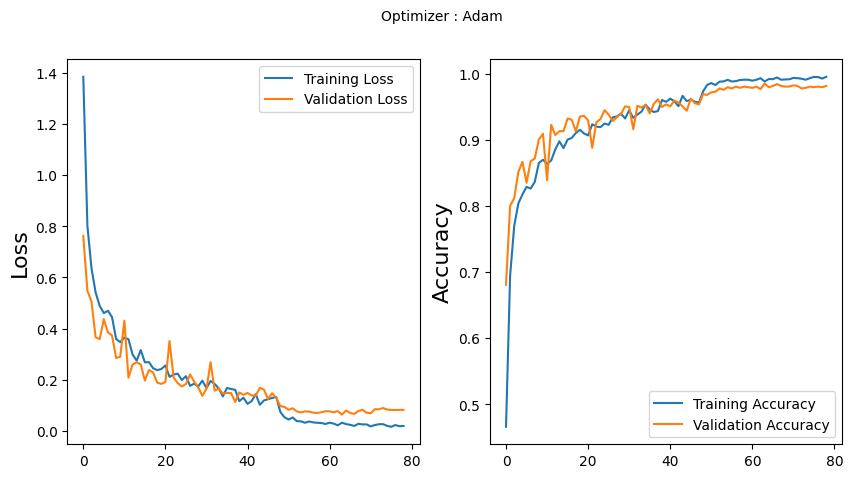

In [13]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()